<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Project with Linear Regression

### Contents:
- [Data Import](#Data-Import)
- [Optimise Ordinal Categories](#Optimise-Ordinal-Categories)
- [Trade Off: Lower RMSE for reduced features and better interpretability](#Trade-Off:-Lower-RMSE-for-reduced-features-and-better-interpretability)
- [Data Visualization](#Visualize-the-Data)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from sklearn.feature_selection import SelectFromModel
# pd.set_option('display.max_rows', 1000)  # or 1000
# pd.set_option('display.max_columns', 1000)  # or 1000

from itertools import combinations
from itertools import permutations

from sklearn.preprocessing import OneHotEncoder

In [2]:
# defining lasso regression to better book kepe journal.
# outputs are X_train, X_test, y_train, y_test, lasso_best
# included indices as well in order to find outliers 

def lasso_reg(X_df,y_series,test_size):
    # assign X and y

    X = X_df
    y = y_series
    indices = X_df.index.values
    
    # Create train/test splits.
    X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
        X,
        y,
        indices,
        test_size=test_size,
        random_state = 123
    )

    # Scale our data.
    # Relabeling scaled data as "Z" is common.
    sc = StandardScaler()
    # Z_train = sc.fit_transform(X_train)
    sc.fit(X_train) # fit should only see train data, 
                    #else if put in test, will have leak from the train data 
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # initiate 
    lasso = LassoCV(
        cv=5,
        max_iter=50000,
        n_alphas=200,
    )

    # Fit model using best ridge alpha!
    lasso.fit(X_train, y_train);

    #fit lasso best with alpha 
    lasso_best = Lasso(alpha = lasso.alpha_)

    # fit lasso best 
    lasso_best.fit(X_train,y_train)

    # cross val mse
    cross_score = - cross_val_score(
        lasso_best,
        X_train,
        y_train,
        cv = 3,
        scoring = 'neg_mean_squared_error'
    ).mean()

    # test mse
    mse_test = mean_squared_error(
        y_test,
        lasso_best.predict(X_test)
    )
    # cross - test 
    mse_train_minus_test = cross_score - mse_test

    if mse_train_minus_test > 0:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Underfited by: {mse_train_minus_test}')
    else:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Overfitted by: {mse_train_minus_test}')
    print(f'RMSE: {mse_test**0.5}')
    print(f'Lasso alpha used: {lasso.alpha_}')
    
    return X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test

### Data Import

In [3]:
# read final refined file 
# refined file contains only optimised ordinal features with high correlation 
# lower ordinal features are put as nominal and processed in models as 1s and 0s using getdummies 


df_main_refined = pd.read_csv('main_refined.csv')
df_main_refined.drop(columns = ['Unnamed: 0'], inplace = True)

In [4]:
df_main_refined

,id,lot_front,lot_area,overall_qual,age,remod_age,exter_qual,bsmt_qual,heating_qc,total_bsmt_sf,...,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD,interaction_1
0,109,69.0552,13517,6,34,5,4,3,5,725.0,...,0,0,0,0,0,0,0,0,1,2.800761e+10
1,544,43.0000,11492,7,13,12,4,4,5,913.0,...,0,0,0,0,0,0,0,0,1,8.079403e+10
2,153,68.0000,7922,5,57,3,3,3,3,1057.0,...,0,0,0,0,0,0,0,0,1,8.258357e+09
3,318,73.0000,9802,5,4,3,3,4,4,384.0,...,0,0,0,0,0,0,0,0,1,1.013500e+10
4,255,82.0000,14235,6,110,17,3,2,3,676.0,...,0,0,0,0,0,0,0,0,1,6.608194e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,1662,80.0000,8000,6,33,33,3,3,3,1084.0,...,0,0,0,0,0,0,0,0,1,1.633175e+10
2925,1234,90.0000,14670,6,42,9,4,3,5,1104.0,...,0,0,0,0,0,0,0,0,1,7.726758e+10
2926,1373,55.0000,8250,5,40,40,3,3,5,952.0,...,0,0,0,0,0,0,0,0,1,1.145416e+10
2927,1672,60.0000,9000,4,36,36,3,3,3,864.0,...,0,0,0,0,0,0,0,0,1,3.903075e+09


In [5]:
# declare main variables 
main_variables = ['lot_front', 'lot_area', 'overall_qual', 'age', 'remod_age',
 'exter_qual', 'bsmt_qual', 'heating_qc', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area',
 'kitchen_qual', 'garage_finish', 'fireplace_qu',
    'sale_price','garage_area','bsmtfin_sf1','tot_rms_abv_grd' ]

**Set up variables**

In [6]:
# dropping these two lines as previously already removed outlier 

df_main_refined.drop(index = [960,1885], inplace = True)

In [7]:
# split test data (Kaggle)
# cross check -->> OK
indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

kaggle_test_final = df_main_refined[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

Indexer: 2049


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
873   NaN
874   NaN
875   NaN
876   NaN
877   NaN
Name: sale_price, Length: 878, dtype: float64

In [8]:
# split train data (Kaggle)
indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

kaggle_train_final = df_main_refined[:indexer]
kaggle_train_final['sale_price'].tail(10)

Indexer: 2049


2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64

**Scale and lasso**

In [9]:
#  scale and lasso 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 451705153.14345676
MSE for test: 342967749.23381364
Underfited by: 108737403.90964311
RMSE: 18519.388468138295
Lasso alpha used: 577.7130877096943


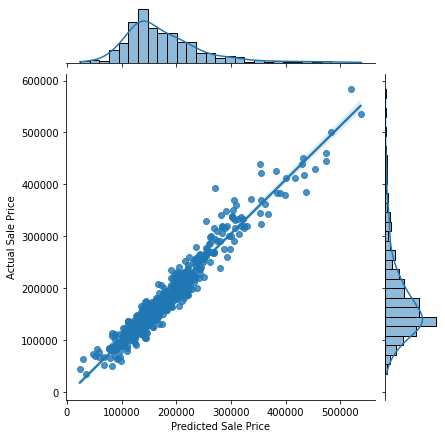

In [10]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

<AxesSubplot:>

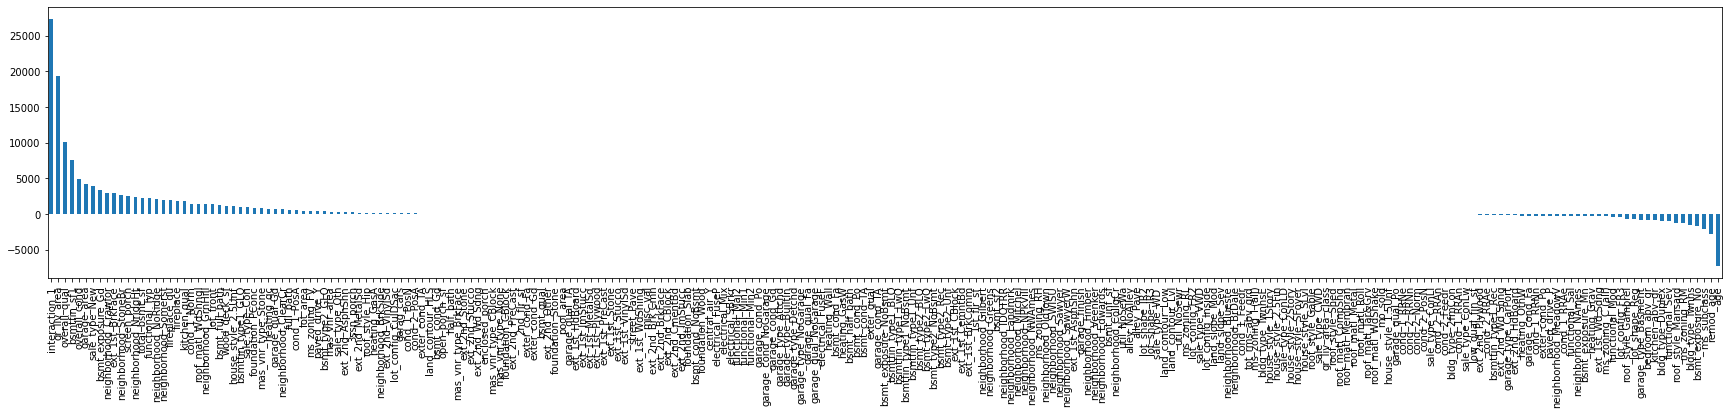

In [11]:
# Series shows alot of zero-ed variables 
# can optimise Lasso by masking 

plt.figure(figsize=(30,5))

col = kaggle_train_final.columns.drop(['sale_price', 'id'])
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

**Optimise model**

In [12]:
# using selectfrommodel to mask using get_support

feature_set_model = SelectFromModel(lasso_best)
feature_set_model.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(alpha=577.7130877096943))

In [13]:
feature_set_model.get_support()

array([ True,  True,  True,  True,  True, False, False,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False, False, False,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False, False, False,  True,  True, False, False,
       False,  True, False, False, False, False, False,  True,  True,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False,  True,  True, False,  True, False, False,
       False,  True, False, False,  True, False,  True, False, False,
        True,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True,  True,  True, False, False,  True,
       False, False,  True, False,  True, False, False, False,  True,
        True, False, False, False, False,  True, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False,

In [14]:
len(feature_set_model.get_support())

239

In [15]:
len(kaggle_train_final.columns)

241

In [16]:
#refined model from 534 columns to 215 columns 

refined = list(kaggle_train_final.columns.drop(['sale_price','id'])[feature_set_model.get_support()])
print(f'Reduced from {len(kaggle_train_final.columns)} to {len(refined)}')


Reduced from 241 to 94


In [17]:
# remove all pairwise features and zero-ed features by Lasso
for col in ['sale_price','id']:
        refined.append(col)

filter_list_of_pairwise = ['garag_cars', '2nd_flr_sf', 'tot_rms_abv_grd', 'bsmt_full_bath', 'half_bath', 'full_bath']

filter_list = [col for col in df_main_refined[refined].columns if col in filter_list_of_pairwise]

# rebuild df main
df_main_refined = df_main_refined[refined].drop(columns = filter_list, axis = 1)

In [18]:
# declare indexcer 
indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

#  split to test and train sets 
kaggle_test_final = df_main_refined[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
print(kaggle_test_final['sale_price'].head(5))

kaggle_train_final = df_main_refined[:indexer]
print(kaggle_train_final['sale_price'].tail(10))

Indexer: 2049
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: sale_price, dtype: float64
2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64


In [19]:
#  scale and lasso with refined variables 
# taking only refined columns 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 424452503.89062566
MSE for test: 342881887.797807
Underfited by: 81570616.09281868
RMSE: 18517.070173162032
Lasso alpha used: 203.91581045719803


Text(27.125, 0.5, 'Actual Sale Price')

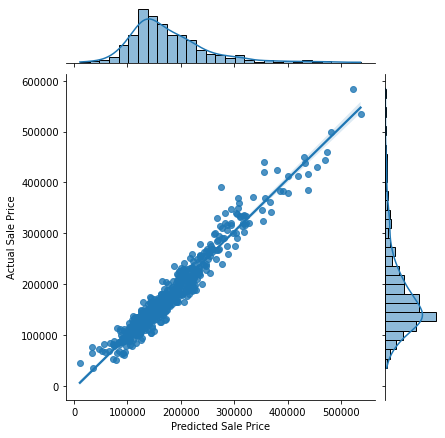

In [20]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax2 = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg',
)
ax2.ax_joint.set_xlabel('Predicted Sale Price')
ax2.ax_joint.set_ylabel('Actual Sale Price')


*comments*

- smaller bias and variance 
- still seeing one anomaly 

**Make Trade-off of higher RMSE for lower amount of features**

In [21]:
# Creating filter df to tell us remaining columns needed for final model

# to create df for lasso coeff

lasso_coeff = pd.DataFrame(lasso_best.coef_)
lasso_coeff.reset_index(drop = True, inplace= True)
lasso_coeff.rename(columns = {0: 'lasso_coeff'}, inplace = True)

# to create df for features 
feat = pd.DataFrame(kaggle_train_final.columns.drop('sale_price'))
feat.reset_index(drop = True, inplace = True)
feat.rename(columns = {0: 'feature'}, inplace = True)


# combine df and filter off columns for 

filter_df = pd.concat([lasso_coeff,feat], axis = 1)

filter_df['feature_in_main'] = filter_df['feature'].map(lambda x: True if x in main_variables else False)
val = 1500
filter_df2 = filter_df[((filter_df['feature_in_main'] == False) &\
            ((filter_df['lasso_coeff'] >= val) | (filter_df['lasso_coeff'] <= -val)) |\
            (filter_df['feature_in_main'] == True))]

print((f'Remaining columns in final model: {len(filter_df2)}'))
filter_df2.sort_values(by = 'feature', ascending = True)

Remaining columns in final model: 32


,lasso_coeff,feature,feature_in_main
3,-7443.169134,age,True
48,-1771.719998,bldg_type_Twnhs,False
67,3137.877642,bsmt_exposure_Gd,False
69,-2369.336038,bsmt_exposure_No,False
11,8454.200789,bsmtfin_sf1,True
40,1790.784464,cond_1_Norm,False
54,3062.293228,ext_1st_BrkFace,False
18,1881.910467,fireplace,False
9,1742.412783,fireplace_qu,True
79,2424.397800,functional_Typ,False


In [22]:
# Extracting Refined columns 
# Noted that we can remove 'neighborhood_class', 'gr_liv_area_class','heating_qc' as they are poor scored against RMSE

remove = ['neighborhood_class', 'gr_liv_area_class']

filter_columns = [col for col in list(filter_df2['feature']) if col not in remove]
filter_columns

['lot_front',
 'lot_area',
 'overall_qual',
 'age',
 'remod_age',
 'heating_qc',
 'total_bsmt_sf',
 'gr_liv_area',
 'kitchen_qual',
 'fireplace_qu',
 'garage_area',
 'bsmtfin_sf1',
 'ms_subclass',
 'overall_cond',
 'fireplace',
 'screen_porch',
 'neighborhood_Crawfor',
 'neighborhood_GrnHill',
 'neighborhood_NoRidge',
 'neighborhood_NridgHt',
 'neighborhood_Somerst',
 'neighborhood_StoneBr',
 'cond_1_Norm',
 'bldg_type_Twnhs',
 'roof_style_Mansard',
 'roof_matl_WdShngl',
 'ext_1st_BrkFace',
 'bsmt_exposure_Gd',
 'bsmt_exposure_No',
 'functional_Typ',
 'sale_type_New',
 'interaction_1']

In [23]:
#  Scale and Lasso regression on refined columns 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final[filter_columns],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 417494379.3177638
MSE for test: 357458013.5659374
Underfited by: 60036365.751826406
RMSE: 18906.560066969807
Lasso alpha used: 67.14889022953922


Text(27.125, 0.5, 'Actual Sale Price')

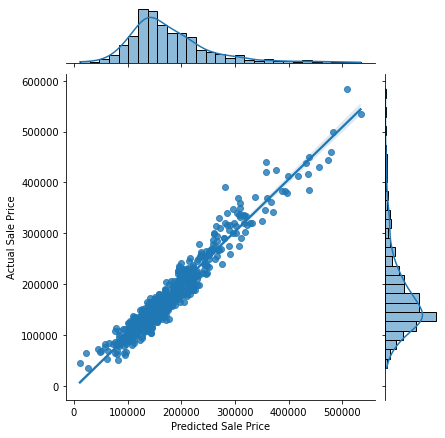

In [24]:
# noticed still have some outliers 

ax2 = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg',
)
ax2.ax_joint.set_xlabel('Predicted Sale Price')
ax2.ax_joint.set_ylabel('Actual Sale Price')


*comments*

Anomoly still observed hence we need to check due to its consistency

Text(0.5, 1.0, 'Predictions vs Residults from Lasso regression')

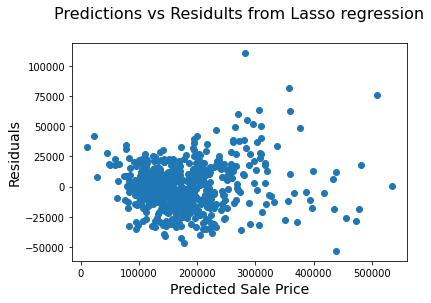

In [25]:
residuals = y_test - lasso_best.predict(X_test)
plt.scatter(lasso_best.predict(X_test), residuals)
plt.xlabel('Predicted Sale Price', fontdict={'fontsize': 14})
plt.ylabel('Residuals', fontdict={'fontsize': 14})
plt.title('Predictions vs Residults from Lasso regression',  fontdict={'fontsize': 16}, pad = 25)

**Comment**

- consistently seeing high outlier 

In [26]:
# find out number 286, 317 having anomaly
anomaly = [num for num,val in enumerate (residuals > 100000) if val == True]
anomaly

[286]

In [27]:
#index with anomoly
anomoly = [indices_test[anol] for anol in anomaly]
anomoly

[1136]

In [28]:
# ID filter into main dataframe
id_filter = [int(df_main_refined.loc[df_main_refined.index == outlier, 'id'].values) for outlier in anomoly]
id_filter

[1641]

In [29]:
# Referencing new set of columns 

final_columns = kaggle_train_final[filter_df2['feature']].drop(columns = ['heating_qc']).columns 

In [30]:
# creating df to compare outliers between holdup and train score

reference_df = pd.concat([df_main_refined[['id','sale_price']],df_main_refined[final_columns]], axis = 1)
reference_df

,id,sale_price,lot_front,lot_area,overall_qual,age,remod_age,total_bsmt_sf,gr_liv_area,kitchen_qual,...,cond_1_Norm,bldg_type_Twnhs,roof_style_Mansard,roof_matl_WdShngl,ext_1st_BrkFace,bsmt_exposure_Gd,bsmt_exposure_No,functional_Typ,sale_type_New,interaction_1
0,109,130500.0,69.0552,13517,6,34,5,725.0,1479,4,...,0,0,0,0,0,0,1,1,0,2.800761e+10
1,544,220000.0,43.0000,11492,7,13,12,913.0,2122,4,...,1,0,0,0,0,0,1,1,0,8.079403e+10
2,153,109000.0,68.0000,7922,5,57,3,1057.0,1057,4,...,1,0,0,0,0,0,1,1,0,8.258357e+09
3,318,174000.0,73.0000,9802,5,4,3,384.0,1444,3,...,1,0,0,0,0,0,1,1,0,1.013500e+10
4,255,138500.0,82.0000,14235,6,110,17,676.0,1445,3,...,1,0,0,0,0,0,1,1,0,6.608194e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,1662,NaN,80.0000,8000,6,33,33,1084.0,1877,3,...,0,0,0,0,0,0,1,1,0,1.633175e+10
2925,1234,NaN,90.0000,14670,6,42,9,1104.0,1988,4,...,1,0,0,0,0,0,1,1,0,7.726758e+10
2926,1373,NaN,55.0000,8250,5,40,40,952.0,1211,3,...,0,0,0,0,0,0,1,1,0,1.145416e+10
2927,1672,NaN,60.0000,9000,4,36,36,864.0,864,3,...,1,0,0,0,0,0,1,1,0,3.903075e+09


In [31]:
# Declare indexer to split between Train and Test sets

indexer = reference_df.shape[0] - len(reference_df[pd.isnull(reference_df['sale_price'])])
print(f'Indexer: {indexer}')

Indexer: 2049


In [32]:
#do cross test split with same random state to keep it consistent

X = reference_df[:indexer].drop(columns = 'sale_price')
y = reference_df[:indexer]['sale_price']

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state = 123
)

In [33]:
# creating holdup reference df
holdup = pd.DataFrame(X_test)
holdup.columns = reference_df.columns.drop('sale_price')
holdup['sale_price'] = y_test
holdup

,id,lot_front,lot_area,overall_qual,age,remod_age,total_bsmt_sf,gr_liv_area,kitchen_qual,fireplace_qu,...,bldg_type_Twnhs,roof_style_Mansard,roof_matl_WdShngl,ext_1st_BrkFace,bsmt_exposure_Gd,bsmt_exposure_No,functional_Typ,sale_type_New,interaction_1,sale_price
564,1039,34.0000,4060,6,10,9,1405.0,1337,4,0,...,0,0,0,0,0,1,1,0,3.065518e+10,181000.0
785,1976,50.0000,6000,6,80,57,845.0,1296,3,0,...,0,0,0,0,0,1,1,0,6.955894e+09,127500.0
553,141,69.0552,8050,5,51,51,1143.0,1143,3,0,...,0,0,0,0,0,1,1,0,8.425071e+09,136000.0
103,728,72.0000,9392,3,109,59,245.0,797,3,0,...,0,1,0,0,0,1,1,0,9.792767e+08,44000.0
1882,1755,69.0552,8740,7,5,5,854.0,1995,4,4,...,0,0,0,0,0,1,1,0,6.427632e+10,219500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,1821,70.0000,7420,5,45,45,1057.0,1057,3,0,...,0,0,0,0,0,1,1,0,7.193176e+09,132000.0
1477,1640,61.0000,8035,9,1,1,1612.0,1612,5,4,...,0,0,0,0,1,0,1,0,1.566406e+11,319900.0
996,2672,65.0000,6435,6,67,56,972.0,1577,2,4,...,0,0,0,0,0,1,1,0,8.025856e+09,140200.0
1909,60,108.0000,14774,9,11,11,1393.0,2599,4,3,...,0,0,0,0,0,1,1,0,2.511713e+11,333168.0


In [34]:
# creating train set reference df
train_set = pd.DataFrame(X_train)
train_set.columns = reference_df.columns.drop('sale_price')
train_set['sale_price'] = y_train
train_set

,id,lot_front,lot_area,overall_qual,age,remod_age,total_bsmt_sf,gr_liv_area,kitchen_qual,fireplace_qu,...,bldg_type_Twnhs,roof_style_Mansard,roof_matl_WdShngl,ext_1st_BrkFace,bsmt_exposure_Gd,bsmt_exposure_No,functional_Typ,sale_type_New,interaction_1,sale_price
807,944,60.0000,10200,4,84,59,572.0,572,3,0,...,0,0,0,0,0,1,1,0,1.193735e+09,75000.0
1317,2596,60.0000,10410,3,76,5,713.0,713,4,0,...,0,0,0,0,0,1,1,0,5.244733e+09,99800.0
655,1037,63.0000,7560,5,37,37,864.0,864,3,0,...,0,0,0,0,0,1,1,0,5.962045e+09,123000.0
1810,547,70.0000,7703,6,17,17,816.0,1730,4,0,...,0,0,0,0,0,1,1,0,3.467153e+10,171500.0
1297,33,53.0000,4043,6,33,33,1069.0,1069,3,2,...,0,0,0,0,0,1,1,0,5.760410e+09,127500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1363,69.0552,10320,5,93,30,880.0,1308,3,0,...,0,0,0,0,0,1,1,0,1.047542e+10,120000.0
1767,1907,80.0000,9600,5,52,52,1078.0,1150,3,0,...,0,0,0,0,0,1,1,0,1.498297e+10,144000.0
1123,14,85.0000,10176,7,20,20,1300.0,1341,4,1,...,0,0,0,0,1,0,1,0,3.277618e+10,171500.0
2014,454,34.0000,5122,6,4,4,1306.0,1306,4,4,...,1,0,0,0,0,0,1,0,3.242693e+10,184500.0


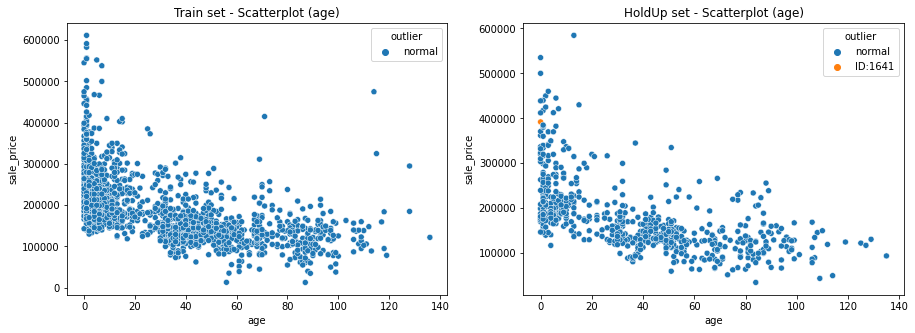

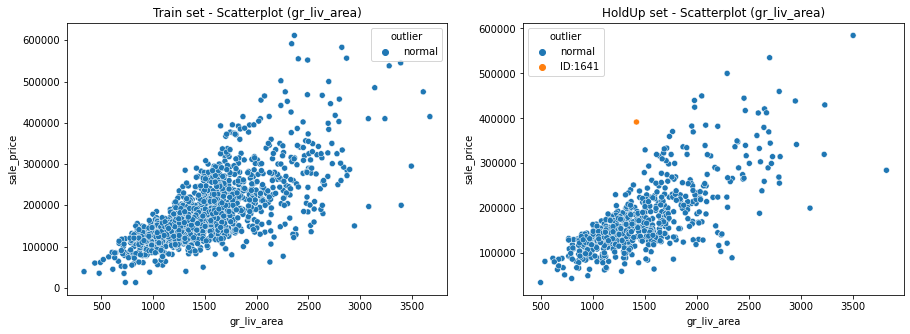

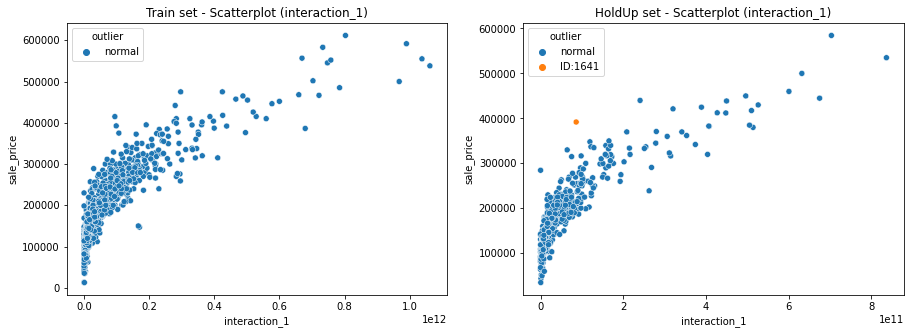

In [35]:
# Creating scatterplot against Sale price for Train and Holdup set

train_set['outlier'] = train_set['id'].map(lambda x: 'ID:1641' if x == id_filter[0] else 'normal')
holdup['outlier'] = holdup['id'].map(lambda x: 'ID:1641' if x == id_filter[0] else 'normal')

for var in ['age','gr_liv_area','interaction_1' ]:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.scatterplot(ax = axes[0], x = var, y = 'sale_price', hue = 'outlier', data = train_set)
    axes[0].set_title(f'Train set - Scatterplot ({var})')
    
    sns.scatterplot(ax = axes[1], x = var, y = 'sale_price' , hue = 'outlier', data = holdup)
    axes[1].set_title(f'HoldUp set - Scatterplot ({var})')

**ID: 1641 Outlier** 
- From gr_liv_area in Holdup set, can see obvious flyer not consistent with Train set  

In [36]:
# **Remove outlier as very abnormal for sale price after renovation**

df_main_refined.drop(index = [1136, 1692], inplace = True)

In [37]:
# Declare indexer to split between Train and Test sets

indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

Indexer: 2047


In [38]:
# declare X and y again

In [39]:
kaggle_test_final = df_main_refined[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
print(kaggle_test_final['sale_price'].head())
kaggle_train_final = df_main_refined[:indexer]
kaggle_train_final['sale_price'].tail(10)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: sale_price, dtype: float64


2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64

In [40]:
# Redo lasso and check on correlation after removal of outliers 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final[filter_columns],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 410230156.24120504
MSE for test: 347827586.0243714
Underfited by: 62402570.21683365
RMSE: 18650.13635404233
Lasso alpha used: 71.36567468219687


In [41]:
# Change in RMSE 

RMSE_before_outlier_removed = 18906.560066969807
RMSE_after_outlier_removed = 18650.13635404233

Difference = RMSE_after_outlier_removed - RMSE_before_outlier_removed
percent_dif = round(Difference/RMSE_before_outlier_removed * 100, 2)
print(f'Current RMSE: {RMSE_after_outlier_removed}')
print(f'Difference in RMSE: {Difference}')
print(f'Percentage diff: {percent_dif}%')

Current RMSE: 18650.13635404233
Difference in RMSE: -256.423712927477
Percentage diff: -1.36%


<AxesSubplot:>

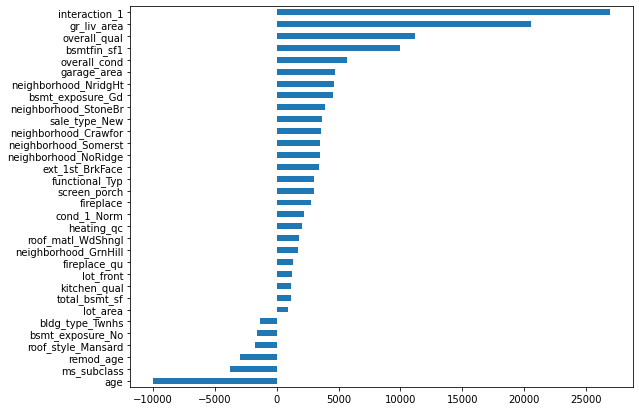

In [42]:
plt.figure(figsize=(9,7))
pd.Series(lasso_best.coef_, index = kaggle_train_final[filter_columns].columns).sort_values(ascending = True).plot.barh()

*comments*

- Insights on neighbourhoods: Houses situatued in these areas have added advantage of 
potentially scalling the price of the house given assuming the rest of the features were constant

In [43]:
# Declare whole train set as X

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
lasso_best.fit(X,y)

Lasso(alpha=71.36567468219687)

In [44]:
# checking train shape 
kaggle_train_final.drop(columns = ['sale_price','id']).shape

(2047, 90)

In [45]:
# checking test shape
kaggle_test_final.drop(columns = ['sale_price','id']).shape

(878, 90)

In [46]:
# checking for any mis match in columns 

for col in kaggle_test_final.columns:
    if col not in kaggle_train_final.columns:
        print(col)

In [47]:
# Submission to kaggle 

In [48]:
# y prediction using whole Train Set
pred = lasso_best.predict(kaggle_test_final.drop(columns = ['sale_price','id']))

In [49]:
# create ID list 
id_list = list(kaggle_test_final['id'])

# create prediction list 
pred_list = list(pred)

# Create CSV 
Submission = pd.DataFrame(list(zip(id_list, pred_list)), columns = ['Id', 'SalePrice'])
Submission

,Id,SalePrice
0,2658,136344.087559
1,2718,153395.171473
2,2414,216174.252606
3,1989,104259.262765
4,625,173740.470831
...,...,...
873,1662,183216.052984
874,1234,216542.922408
875,1373,123014.044429
876,1672,116596.537604


In [50]:
Submission.to_csv('Submission_Lasso.csv')

In [51]:
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train);

ridge_best = Ridge(alpha = ridge_cv.alpha_)

ridge_best.fit(X_train,y_train)

# cross val mse
cross_score = - cross_val_score(
    ridge_best,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    ridge_best.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')
print(f'Alpha used: {ridge_cv.alpha_}')

MSE for train: 410070117.31212467
MSE for test: 345505343.1605395
Underfited by: 64564774.15158516
RMSE: 18587.774023818438
Alpha used: 25.95024211399736


In [52]:
X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']

ridge_best.fit(X,y)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.06333e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Ridge(alpha=25.95024211399736)

In [53]:
pred = ridge_best.predict(kaggle_test_final.drop(columns = ['sale_price','id']))

In [54]:
# create ID list 
id_list = list(kaggle_test_final['id'])

# create prediction list 
pred_list = list(pred)

# Create CSV 
Submission_Ridge = pd.DataFrame(list(zip(id_list, pred_list)), columns = ['Id', 'SalePrice'])
Submission_Ridge

,Id,SalePrice
0,2658,138115.739945
1,2718,152873.946474
2,2414,217414.935971
3,1989,103803.514699
4,625,173376.641268
...,...,...
873,1662,184909.421997
874,1234,216457.599162
875,1373,123312.091193
876,1672,115579.323703


In [55]:
Submission.to_csv('Submission_Ridge.csv')

**Key Takeaways**

1) Understanding interaction terms in consumer’s POV and putting into Data science concepts 
   
2) Not all ordinal categories should be given sequential scoring, else unnecessary amplication can ruin predictions 

3) Need to train test split properly to avoid data leakage from TEST data